In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import time
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#matplot lib notebooks display command
%matplotlib inline

#SET OPTIONS
pd.options.display.float_format = '{:,.2f}'.format
#GLOBAL VARIABLES
today = datetime.date.today()
os.chdir('C:\\Users\\ahilgenkamp\\Documents\\Grad School\\Applied Machine Learning\\Project\\Data')
cwd = os.getcwd()

Using TensorFlow backend.


In [2]:
#load dataset
#old dataset: non_automated_invoices_with_acct_info.csv
non_auto_df = pd.read_csv(cwd+'\\invoices_with_acct_and_cases.csv', encoding='utf-8')
non_auto_df.dtypes

INVOICE_ID                object
ACCT_ID                   object
CR_CHK_CD                 object
CUST_STAT                 object
PYDX_SCRE_NUM            float64
INDUSTRY_NM               object
CURR_NUM_LICENSES        float64
USAGE_SCORE              float64
EMP_CNT                  float64
CRNCY_ISO_CD              object
CUSTOMER_REVENUE         float64
DUE_MONTH                  int64
COLLECTOR                 object
COLLECTION_STATUS         object
HAS_TAX_EXEMP               bool
BILLING_COUNTRY           object
BILLING_LANGUAGE          object
PAYMENT_TERM              object
PAYMENT_TYPE              object
COMMENT_LENGTH             int64
HAS_30DAY_EXTXN             bool
PAST_DUE_FLG                bool
LATE_PMT_GT_30              bool
BAD_DEBT_FLAG             object
DAYS_TO_PAY                int64
CURRENCY_CODE             object
TOTAL_AMOUNT             float64
BALANCE_DUE                int64
WRITEOFF_AMT             float64
BILL_FREQ_NUM              int64
TOTAL_NUMB

In [3]:
def pre_process(df, dropcols=None):
    '''
    The pre_process function that will return a transformed dataframe
    Notes:
        1) dropcols should be a list
        2) integer varibles are transformed using mean normalization
    '''
    #drop columns input by the user
    if dropcols is not None:
        df = df.drop(columns=dropcols)
    
    #loop through remaining columns and apply the appropreate transform
    for i in df.columns:
        #mean normalization for int variables
        if df[i].dtype == "int64" or df[i].dtype == 'float64':
            mean = df[i].mean()
            if (df[i].max() - df[i].min()) == 0:
                denom = 1
            else:
                denom = (df[i].max() - df[i].min())
            df[i] = df[i].apply(lambda x: float(x - mean) / denom)
        #convert bool values to 1 and 0
        elif df[i].dtype == "bool":
            df[i] = df[i].map({True: 1, False: 0})
        #convert True and False to 1 and 0
        elif df[i].dtype == "object" and "True" in set(df[i].tolist()) and "False" in set(df[i].tolist()): 
            df[i] = df[i].map({'True': 1, 'False': 0})
        elif df[i].dtype == "object":
            df = pd.get_dummies(df, columns=[i], prefix=[i], dtype="int8") #, sparse=True
        
    return df

clean_df = pre_process(non_auto_df, dropcols=['BAD_DEBT_FLAG','INVOICE_ID','ACCT_ID','WRITEOFF_AMT',
                                              'BALANCE_DUE','NUM_NONPMT_CASES','CRNCY_ISO_CD'])
print(clean_df.shape)

(284771, 499)


In [4]:
X = clean_df
y = non_auto_df['BAD_DEBT_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

print(X_train.shape)
print(y_train.shape)

(182252, 499)
(182252,)


In [5]:
print('Original dataset shape %s' % Counter(y_train))

#Need to balance the dataset
sm = SMOTE(sampling_strategy='not majority', random_state=7)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({'Paid in Full': 173691, '>10% Write Off': 4369, '<10% Write Off': 2692, 'Total Write Off': 1500})
Resampled dataset shape Counter({'Paid in Full': 173691, '>10% Write Off': 173691, 'Total Write Off': 173691, '<10% Write Off': 173691})


In [6]:
print(X_res.shape)

(694764, 499)


Model with Regularization Coef 0.1 completed in 171.984sec | Accuracy = 72.54%
Model with Regularization Coef 0.5 completed in 455.734sec | Accuracy = 72.7%
Model with Regularization Coef 1 completed in 603.156sec | Accuracy = 72.73%
Model with Regularization Coef 5 completed in 1892.078sec | Accuracy = 72.78%
Model with Regularization Coef 10 completed in 3037.922sec | Accuracy = 72.79%
Model with Regularization Coef 20 completed in 4499.438sec | Accuracy = 72.82%


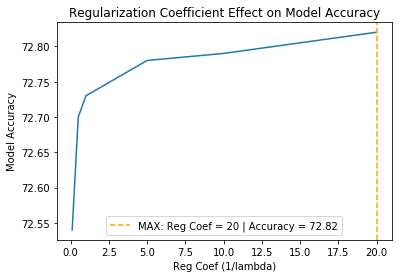

In [7]:
regCoef_list = [0.1,0.5,1,5,10,20] 
accuracy_list = []

for c in regCoef_list:
    start = time.process_time()
    logreg = linear_model.LogisticRegression(solver="saga", C=c, max_iter=1000, penalty='l2', multi_class='multinomial', verbose=0)
    logreg.fit(X=X_res, y=y_res)
    score = logreg.score(X_valid, y_valid)
    accuracy_list.append(round(score*100,2))
    end = time.process_time()
    print('Model with Regularization Coef '+str(c)+' completed in '+str(round(end-start,3))+'sec | Accuracy = '+str(round(score*100,2))+'%')

plt.plot(regCoef_list, accuracy_list)
plt.axvline(x=regCoef_list[accuracy_list.index(max(accuracy_list))], color='orange', linestyle='--', 
            label='MAX: Reg Coef = {}'.format(regCoef_list[accuracy_list.index(max(accuracy_list))])+
            ' | Accuracy = {}'.format(max(accuracy_list)))
plt.title("Regularization Coefficient Effect on Model Accuracy")
plt.xlabel("Reg Coef (1/lambda)")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

In [9]:
#basically the same accuracy as the coef changes so using c=1
logreg = linear_model.LogisticRegression(solver="saga", C=1, max_iter=5000, penalty='l2', 
                                         multi_class='multinomial', verbose=1)
logreg.fit(X=X_res, y=y_res)

y_hat = logreg.predict(X_test)
score = accuracy_score(y_test, y_hat)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 74 epochs took 669 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.2min finished


Model Accuracy: 73.16


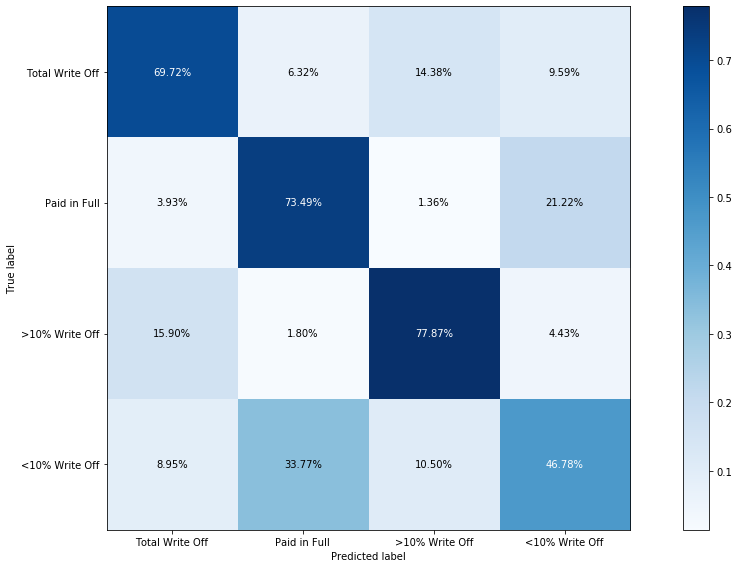

In [10]:
def plotConfusionMatrix(y_test, y_hat, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_hat, labels=classes)   
    
    if normalize == True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(15,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2%' if normalize == True else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print('Model Accuracy: '+str(round(score*100,2)))
plotConfusionMatrix(y_test, y_hat, classes=['Total Write Off','Paid in Full','>10% Write Off','<10% Write Off'], 
                                    normalize=True)
plt.show()

Test Accuracy: 93.95%


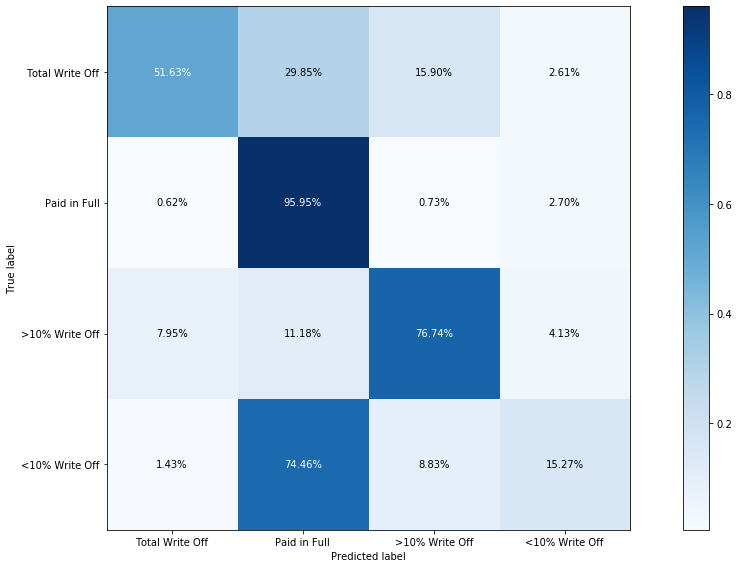

In [11]:
#train model base on best parameters from training / validation phase
decision_tree = DecisionTreeClassifier() #max_depth=12
decision_tree.fit(X_res, y_res)

#print test accuracy and plot confusion matrix
print('Test Accuracy: '+str(round(decision_tree.score(X_test, y_test)*100,2))+'%')
y_hat = decision_tree.predict(X_test)
plotConfusionMatrix(y_test, y_hat, classes=['Total Write Off','Paid in Full','>10% Write Off','<10% Write Off'],
                    normalize=True)
plt.show()

Model with max depth 3 completed in 33.906sec | Accuracy = 65.44%
Model with max depth 5 completed in 47.109sec | Accuracy = 70.63%
Model with max depth 8 completed in 66.781sec | Accuracy = 79.22%
Model with max depth 10 completed in 77.359sec | Accuracy = 75.05%
Model with max depth 12 completed in 83.234sec | Accuracy = 79.21%
Model with max depth 15 completed in 85.469sec | Accuracy = 87.22%
Model with max depth 20 completed in 106.469sec | Accuracy = 89.77%
Model with max depth 25 completed in 109.094sec | Accuracy = 92.61%
Model with max depth 50 completed in 144.562sec | Accuracy = 93.64%
Model with max depth 100 completed in 152.656sec | Accuracy = 93.82%


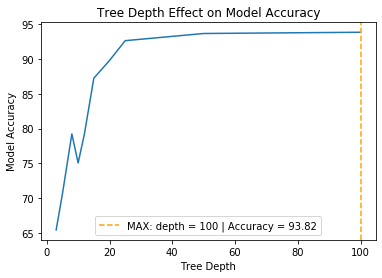

In [12]:
depth_list = [3,5,8,10,12,15,20,25,50,100] #focusing around 10 layers deep as that provides the best accuracy 
accuracy_list = []

for d in depth_list:
    start = time.process_time()
    decision_tree = DecisionTreeClassifier(max_depth=d)
    decision_tree = decision_tree.fit(X_res, y_res)
    score = decision_tree.score(X_valid, y_valid)
    accuracy_list.append(round(score*100,2))
    end = time.process_time()
    print('Model with max depth '+str(d)+' completed in '+str(round(end-start,3))+'sec | Accuracy = '+str(round(score*100,2))+'%')

plt.plot(depth_list, accuracy_list)
plt.axvline(x=depth_list[accuracy_list.index(max(accuracy_list))], color='orange', linestyle='--', 
            label='MAX: depth = {}'.format(depth_list[accuracy_list.index(max(accuracy_list))])+
            ' | Accuracy = {}'.format(max(accuracy_list)))
plt.title("Tree Depth Effect on Model Accuracy")
plt.xlabel("Tree Depth")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

Test Accuracy: 79.41%


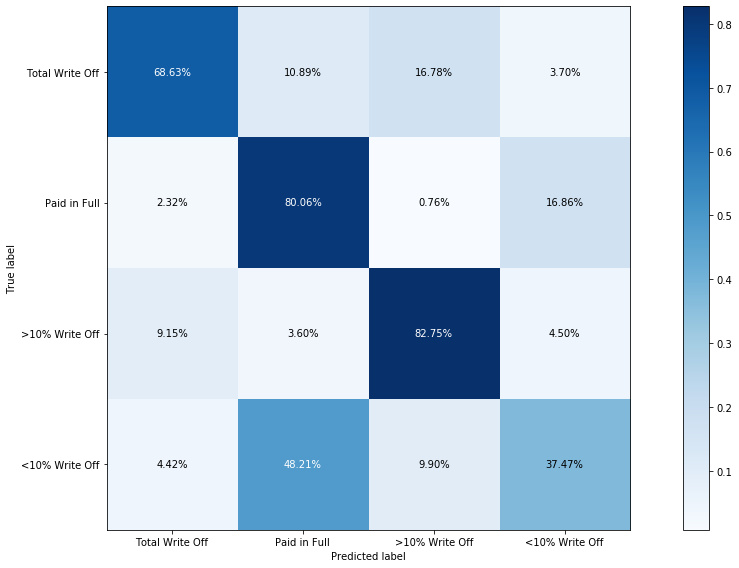

In [13]:
#train model base on best parameters from training / validation phase
decision_tree = DecisionTreeClassifier(max_depth=12)
decision_tree.fit(X_res, y_res)

#print test accuracy and plot confusion matrix
print('Test Accuracy: '+str(round(decision_tree.score(X_test, y_test)*100,2))+'%')
y_hat = decision_tree.predict(X_test)
plotConfusionMatrix(y_test, y_hat, classes=['Total Write Off','Paid in Full','>10% Write Off','<10% Write Off'],
                    normalize=True)
plt.show()

Model fit complete
Ada boost model completed in 2926.469sec | Train Accuracy = 85.15%
Test Accuracy: 85.08%


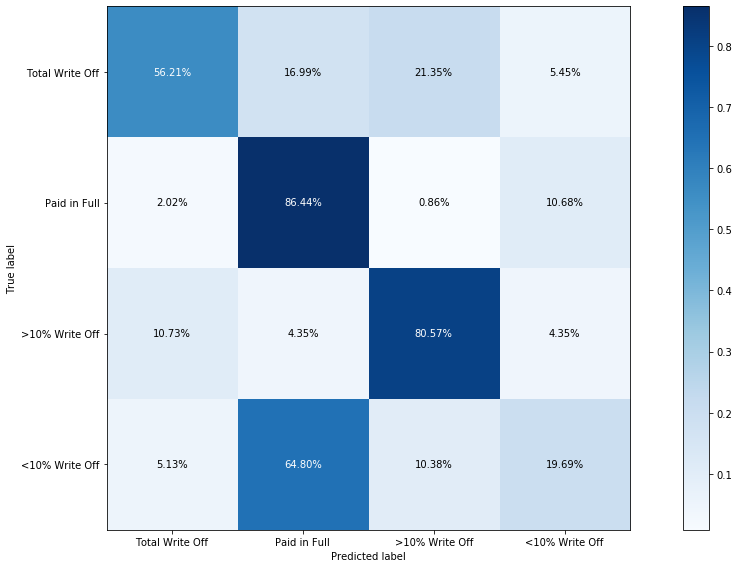

In [15]:
#using max depth of 12 from previous tree
#takes a long time to run
from sklearn.ensemble import AdaBoostClassifier
start = time.process_time()
abc = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=1))
abc.fit(X_res, y_res)
print('Model fit complete')
score = abc.score(X_valid, y_valid)
end = time.process_time()
print('Ada boost model completed in '+str(round(end-start,3))+'sec | Train Accuracy = '+str(round(score*100,2))+'%')

#gbc = GradientBoostingClassifier(n_estimators=250, learning_rate=0.01, max_depth=10, verbose=1, n_iter_no_change=1, max_features='sqrt') 
#gbc.fit(X_res, y_res)

#print test accuracy and plot confusion matrix
print('Test Accuracy: '+str(round(abc.score(X_test, y_test)*100,2))+'%')
y_hat = abc.predict(X_test)
plotConfusionMatrix(y_test, y_hat, classes=['Total Write Off','Paid in Full','>10% Write Off','<10% Write Off'], normalize=True)
plt.show()

## Example of Building Model with Imbalanced Data

Test Accuracy: 97.15%


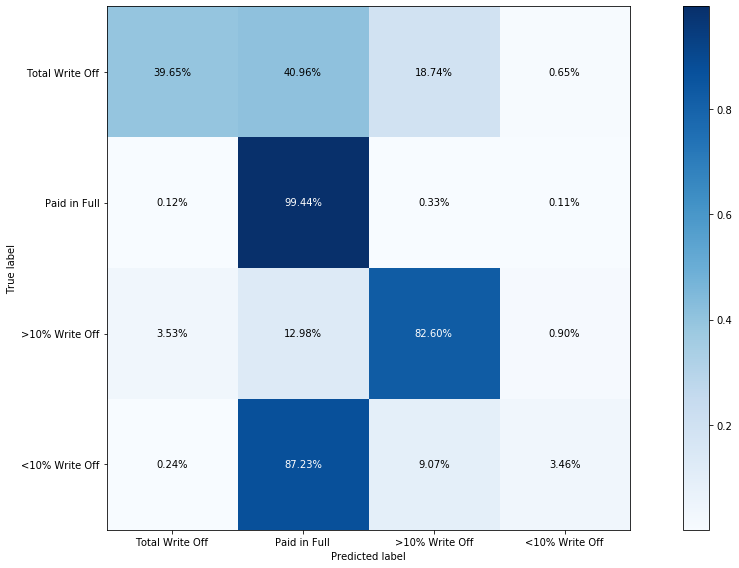

In [14]:
#show imbalanced results
#train model base on best parameters from training / validation phase
decision_tree_imbal = DecisionTreeClassifier(max_depth=12)
decision_tree_imbal.fit(X_train, y_train)

#print test accuracy and plot confusion matrix
print('Test Accuracy: '+str(round(decision_tree_imbal.score(X_test, y_test)*100,2))+'%')
y_hat = decision_tree_imbal.predict(X_test)
plotConfusionMatrix(y_test, y_hat, classes=['Total Write Off','Paid in Full','>10% Write Off','<10% Write Off'],
                    normalize=True)
plt.show()